In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline.load import load_data
from reproduction import analysis
import sklearn

In [2]:
from reproduction.pipeline import into_record

In [60]:
from scipy import fftpack
from matplotlib.colors import LogNorm

In [119]:
from scipy.stats import wasserstein_distance

In [3]:
# open/closed cell data dir
CLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_close"
CLOSEDS = CLOSEDATADIR+"/closed.tfrecord"
OPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open"
OPENS = OPENDATADIR+"/open.tfrecord"

# same brightness but no texture to open/closed cell data dir
BCLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN30MOD09GA_ambiguous_closed"
BCLOSEDS = BCLOSEDATADIR+"/bright_closed.tfrecord"
BOPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN31MOD09GA_ambiguous_open"
BOPENS = BOPENDATADIR+"/bright_open.tfrecord"

# outputdata dir
OUTPUTDIR="/project/foster/clouds/output"
CENTERS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc.cluster_centres"
ENCODER_DEF = OUTPUTDIR+"/mod09cnn15b/encoder.json"
ENCODER_WEIGHTS = OUTPUTDIR+"/mod09cnn15b/encoder-585000.h5"
ENCODINGS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc"

In [4]:
centers = analysis.read_kmeans_centers(CENTERS)

In [5]:
k = KMeans(n_clusters=centers.shape[0], init=centers)

In [6]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

In [8]:
N=30  # number of patches
opens = analysis.AEData(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=N)
closeds = analysis.AEData(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False), n=N)
bopens = analysis.AEData(load_data(BOPENS, encoder.input_shape[1:], repeat=False), n=N)
bcloseds = analysis.AEData(load_data(BCLOSEDS, encoder.input_shape[1:], repeat=False), n=N)

In [9]:
opens.add_encoder(encoder)
closeds.add_encoder(encoder)
bopens.add_encoder(encoder)
bcloseds.add_encoder(encoder)

## Image Data

In [11]:
# TODO: include in analysis.py 
def _get_imgs(dataset, ae=None, fields=None, n=500):
        # get data from dataset
        names, coords, imgs = [], [], []
        batch = dataset.make_one_shot_iterator().get_next()
        with tf.Session() as sess:
            while len(imgs) < n:
                names_, coords_, imgs_ = sess.run(batch)
                names.extend(names_)
                coords.extend(coords_)
                imgs.extend(imgs_)
        return imgs

In [12]:
oimgs = _get_imgs(load_data(OPENS, encoder.input_shape[1:], repeat=False), n=30)
cimgs = _get_imgs(load_data(CLOSEDS, encoder.input_shape[1:], repeat=False), n=30)
_oimgs = _get_imgs(load_data(BOPENS, encoder.input_shape[1:], repeat=False), n=30)
_cimgs = _get_imgs(load_data(BCLOSEDS, encoder.input_shape[1:], repeat=False), n=30)

In [33]:
oimgs_array = np.asarray(oimgs)
cimgs_array = np.asarray(cimgs)
_oimgs_array = np.asarray(_oimgs)
_cimgs_array = np.asarray(_cimgs)

In [18]:
oimgs_array.shape

(32, 128, 128, 7)

## Cluster

In [46]:
#  cluster
k.cluster_centers_ = centers
# Number of Clusters 
num_clusters = 10
# Append
oc = np.append(opens.encs,closeds.encs, axis=0)
boc = np.append(bopens.encs,bcloseds.encs, axis=0)
both = np.append(oc, boc,  axis=0)

In [47]:
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o, c, bo, bc = clusters[:N], clusters[N:N*2], clusters[N*2:N*3], clusters[N*3:]

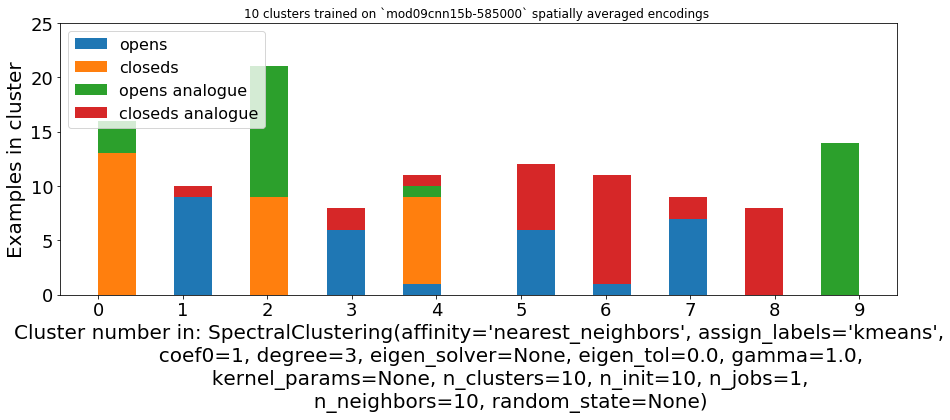

In [48]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([0,5,10,15,20, 25])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

# Plot Other radiance

## Cluster ==5 Opens vs Closeds analogue 

6


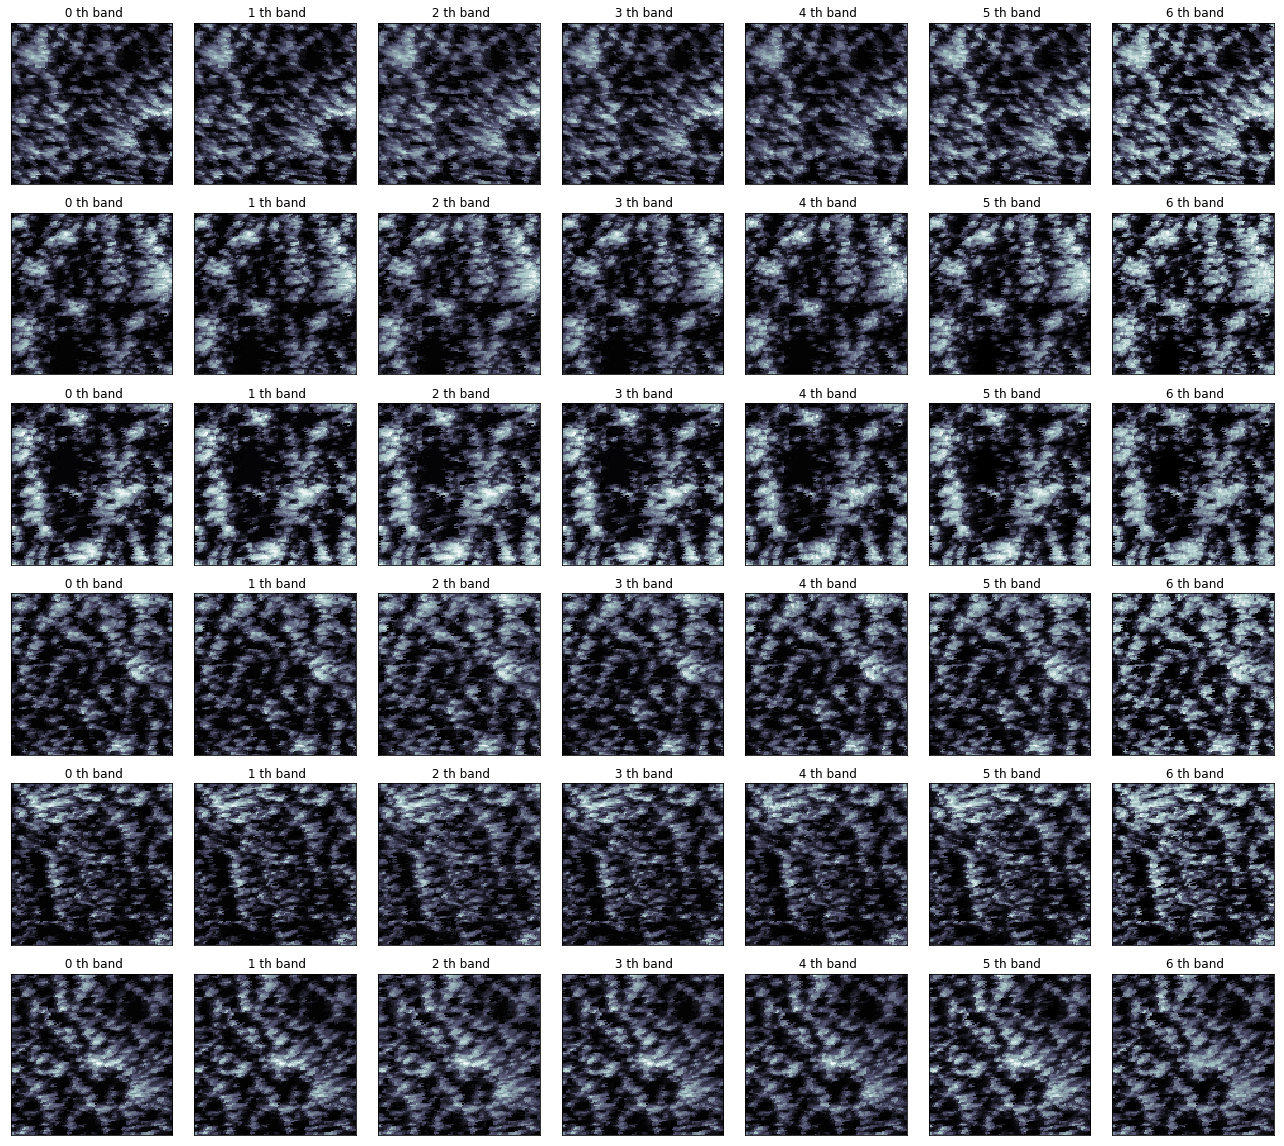

In [51]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(o == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(o == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(o == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.imshow(oimgs_array[i[0],:,:,ir], norm=None, cmap="bone")
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

6


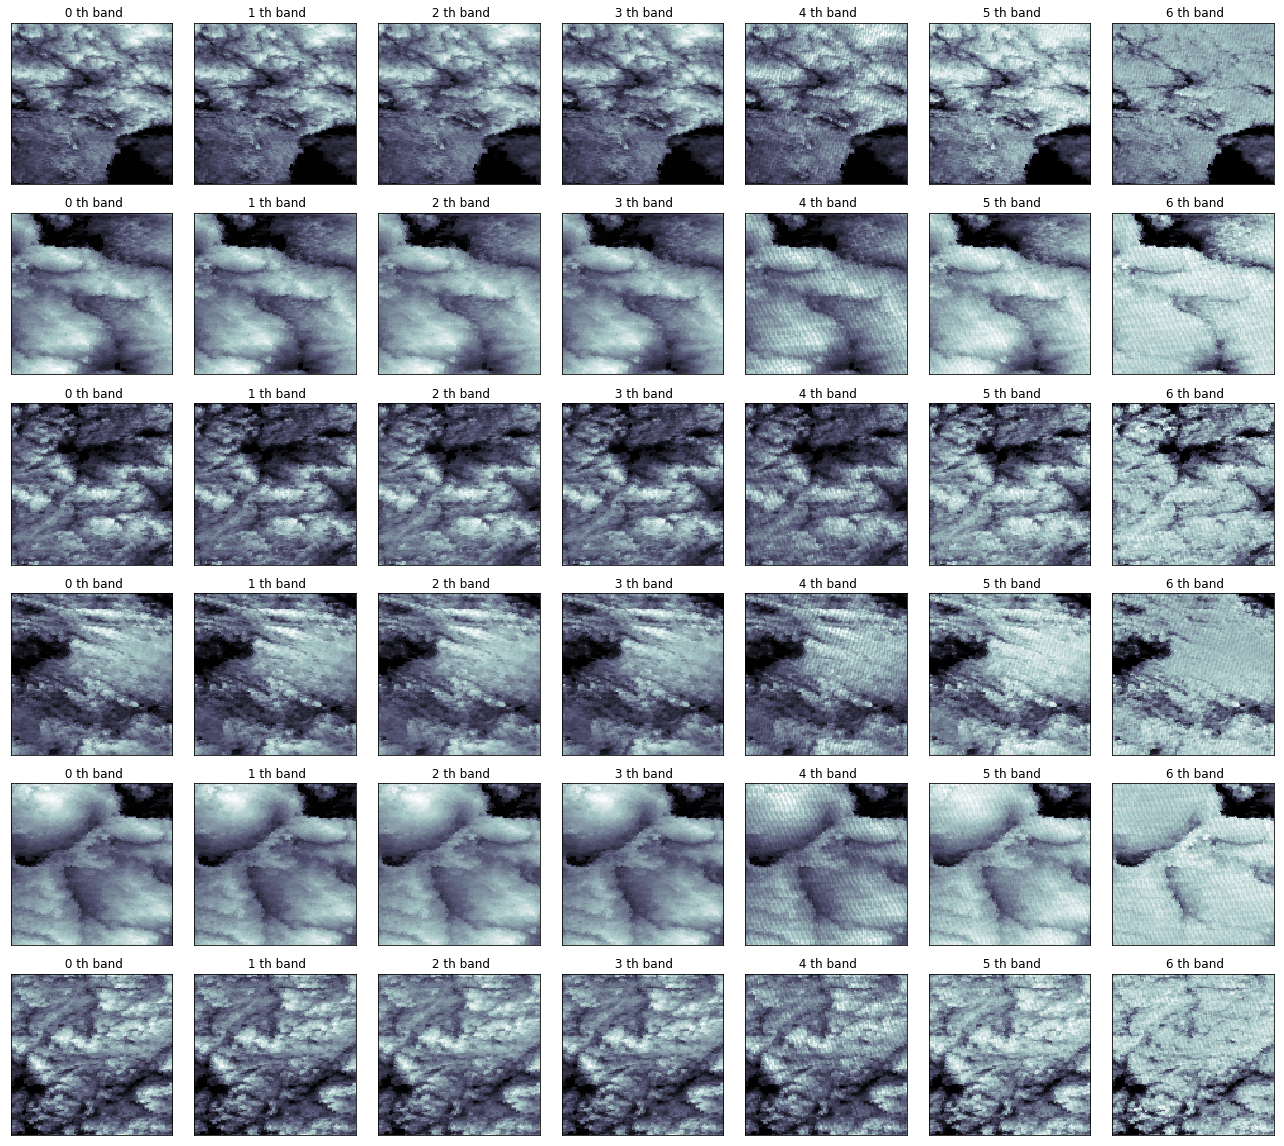

In [52]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(bc == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bc == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bc == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.imshow(_cimgs_array[i[0],:,:,ir], norm=None, cmap="bone")
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

## Numerical check 

Histogram of original image

6


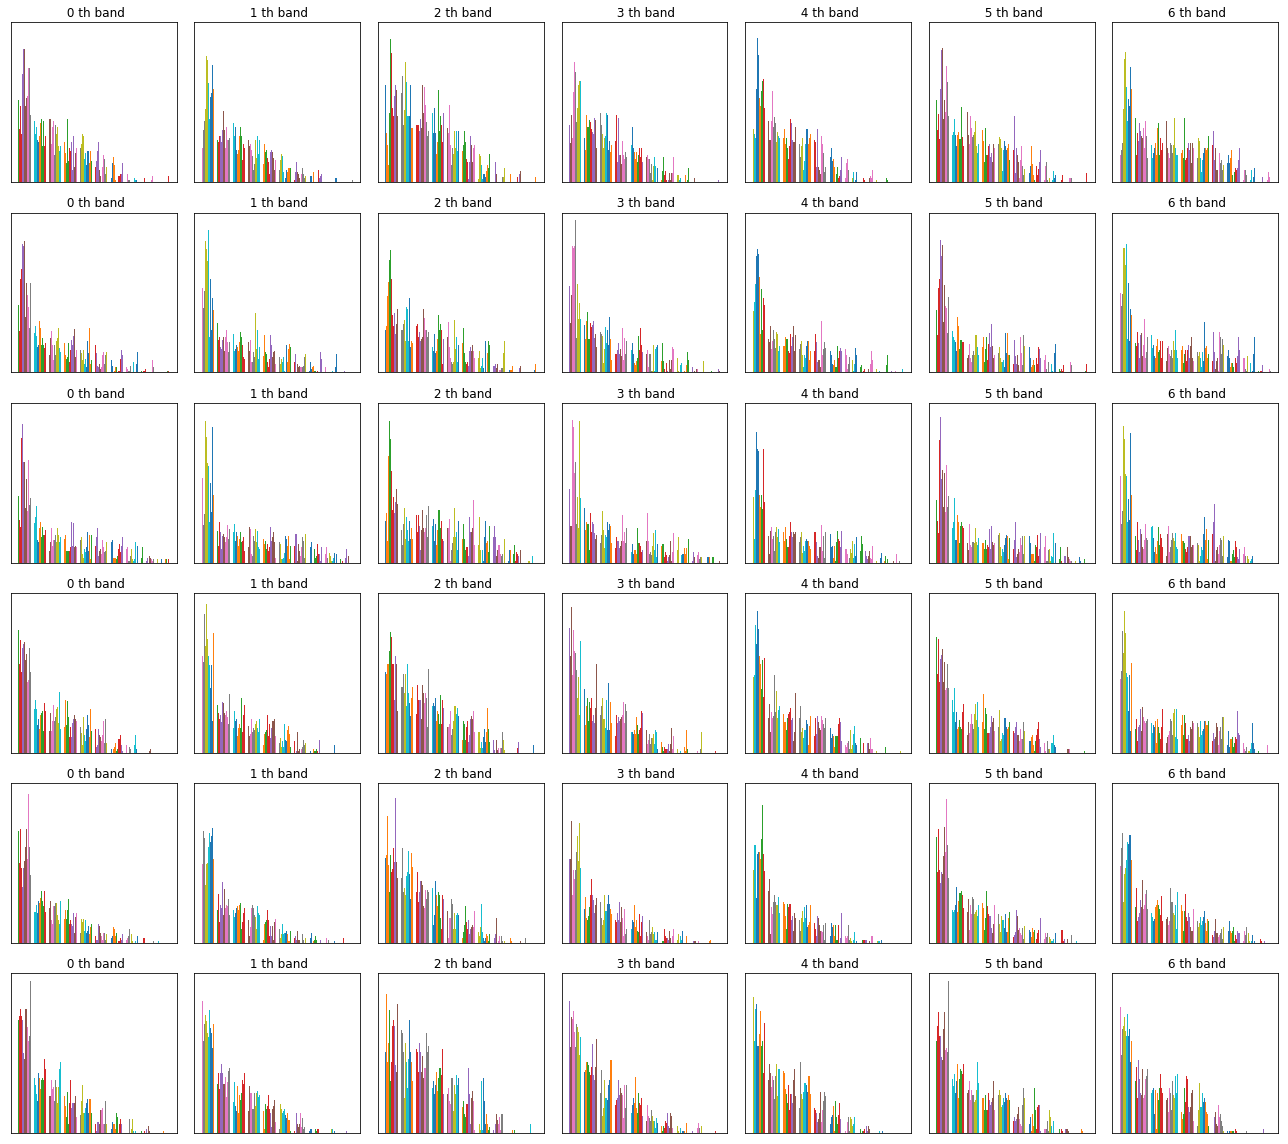

In [54]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(o == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(o == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(o == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.hist(oimgs_array[i[0],:,:,ir])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

6


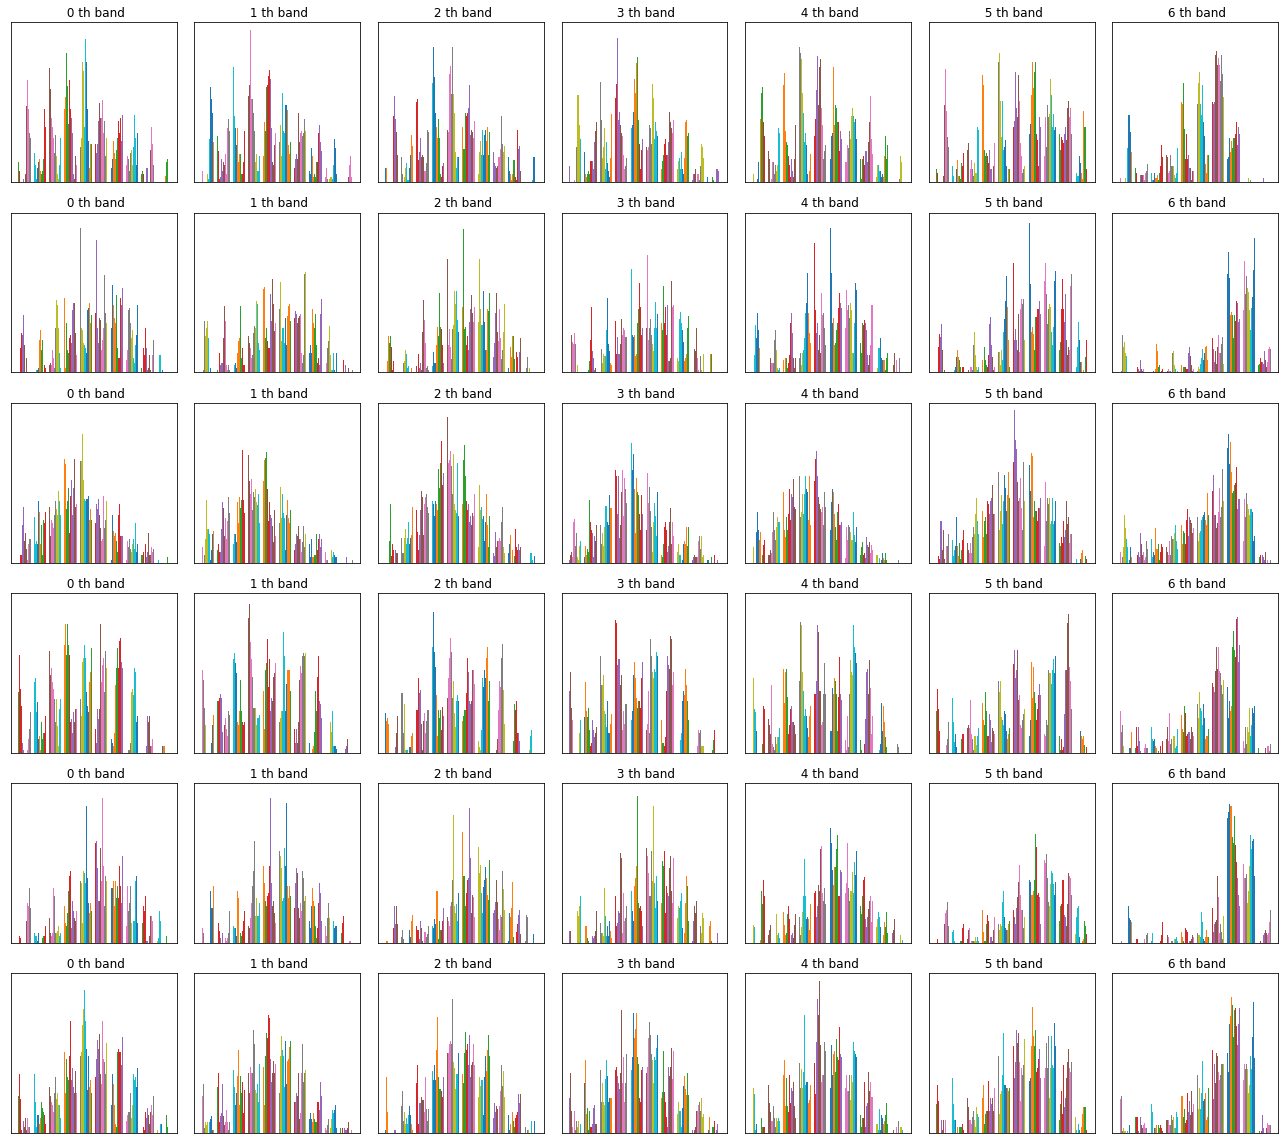

In [55]:
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(bc == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bc == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bc == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        plt.hist(_cimgs_array[i[0],:,:,ir])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

FFT for images

In [71]:
def get_spectrum(fft_array):
    # freq, ps
    freq = fftpack.fftfreq(fft_array.size)
    idx  = np.argsort(freq)
    ps   = np.abs(fft_array)**2 # poer spectrum 
    
    return freq, ps, idx

6


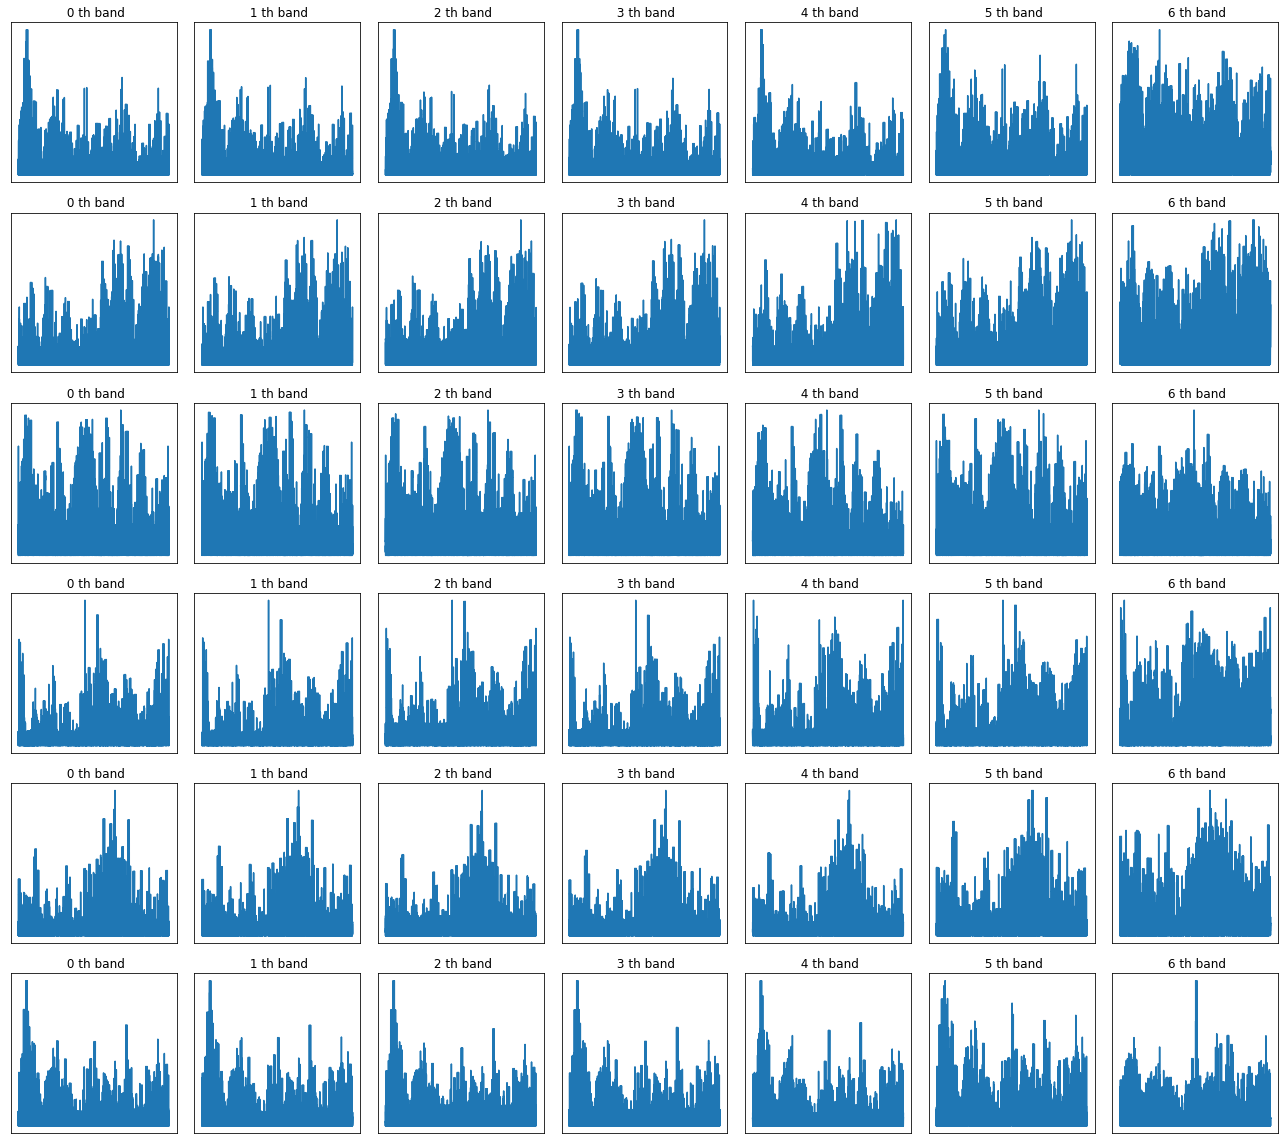

In [72]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(o == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(o == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(o == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = oimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

6


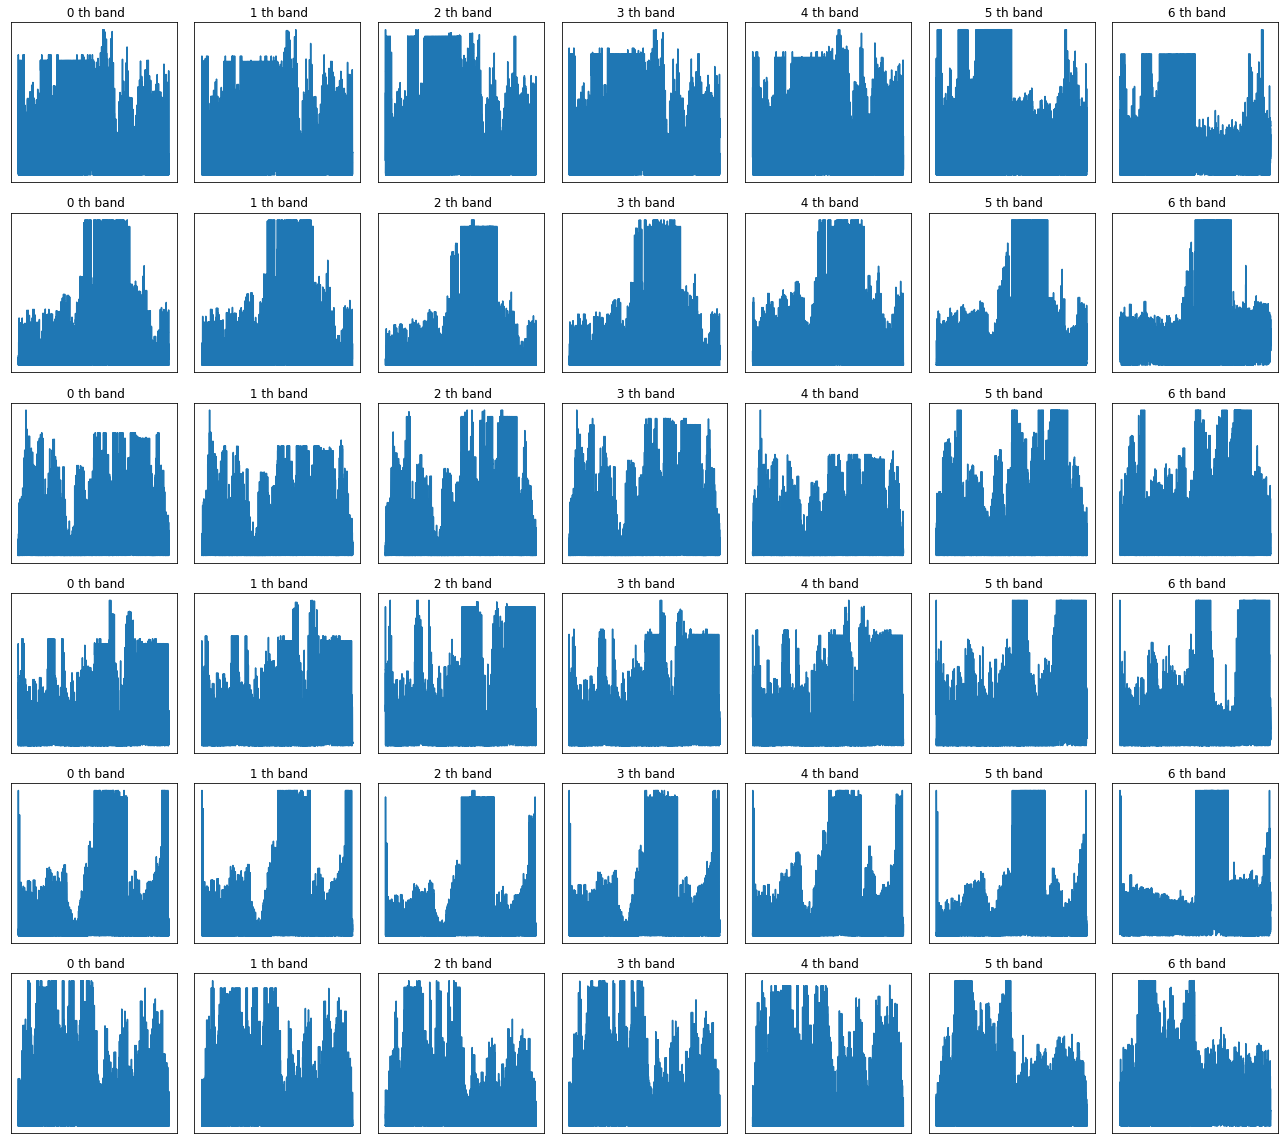

In [73]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 5
print(len(np.argwhere(bc == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bc == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bc == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = _cimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

When analyzed by FFT, original images in opens and closed analogues have little bit similar bimodal like distribution. Is this key points??

### Another cluster: cluster  2

9


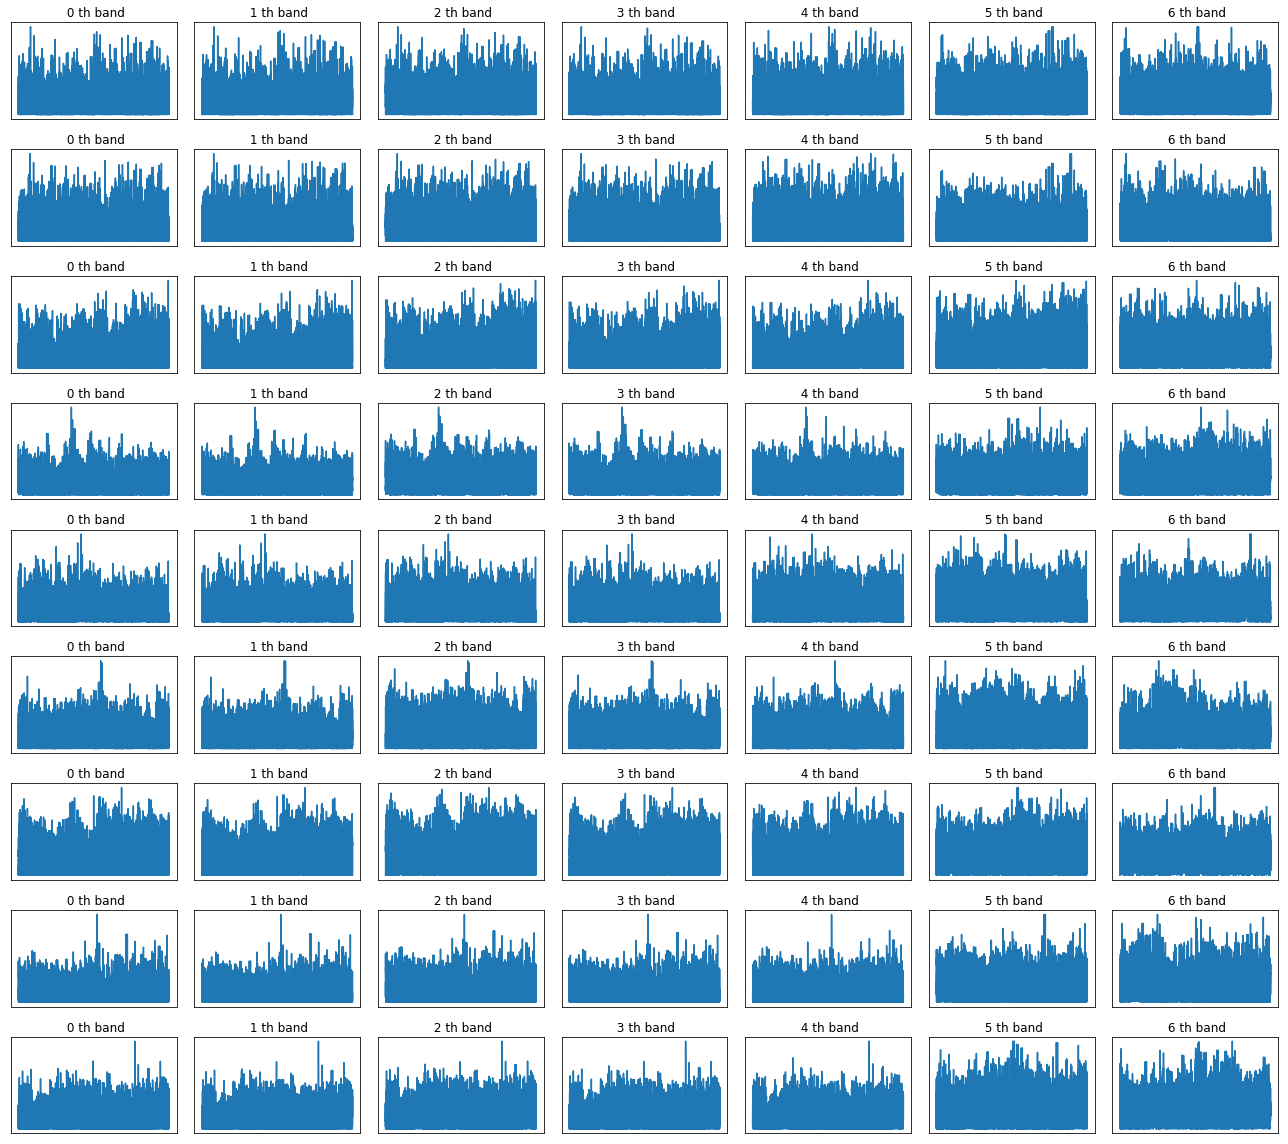

In [76]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 2
print(len(np.argwhere(c == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(c == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(c == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = cimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

12


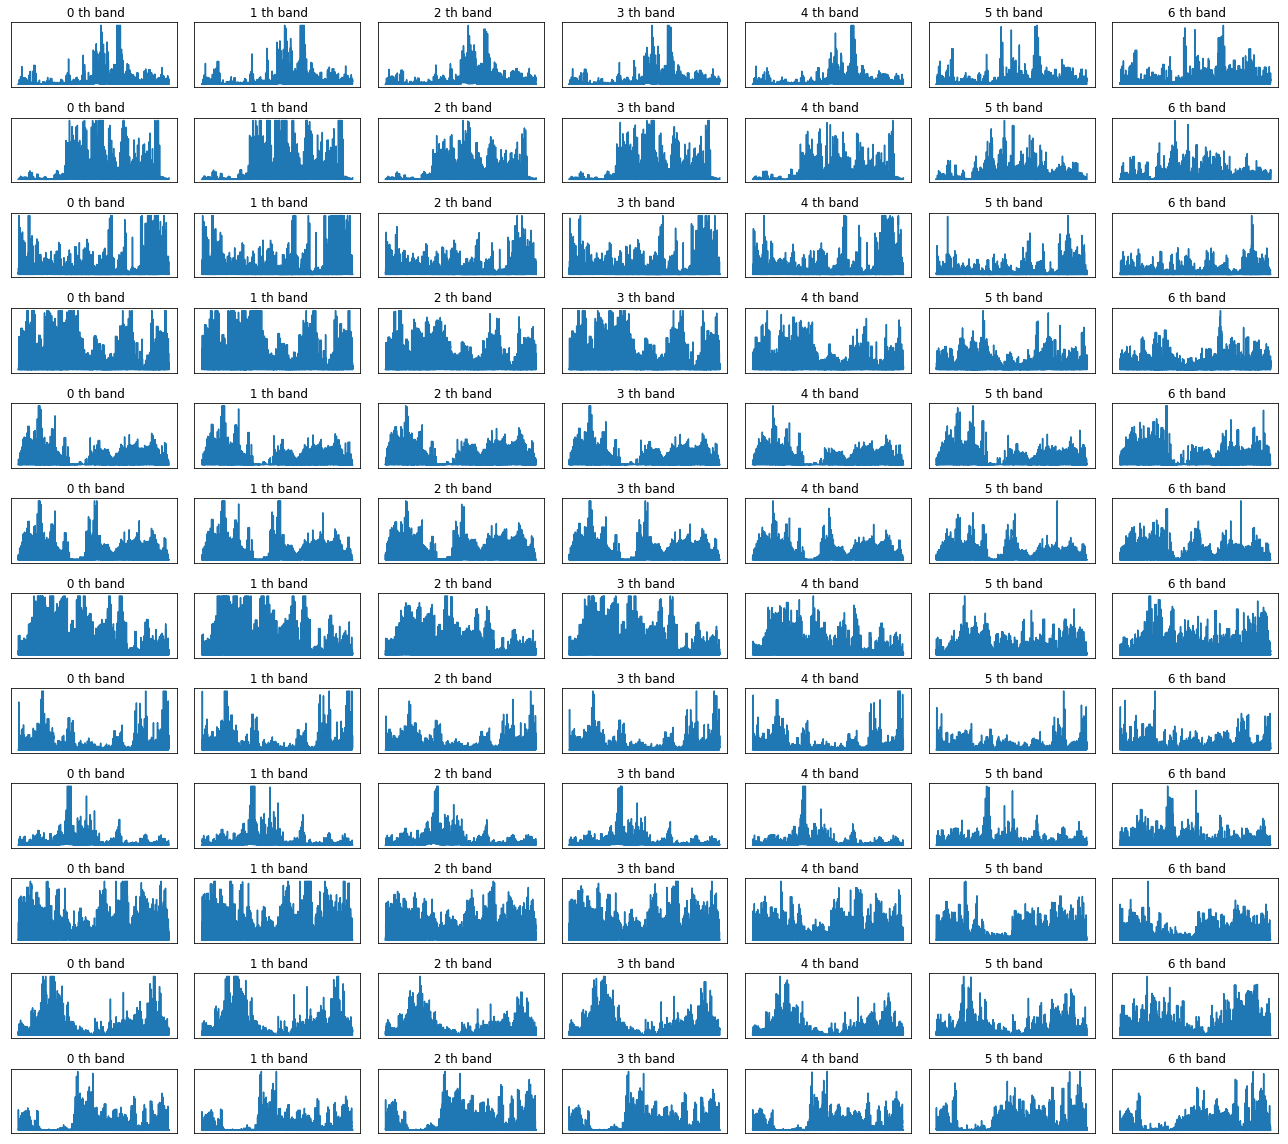

In [78]:
# power spectrum
fig = plt.figure(figsize=(18,16))
cluster = 2
print(len(np.argwhere(bo == cluster)))
icount = 0
for ix , i in enumerate(np.argwhere(bo == cluster)):
    for ir in range(7):
        ax=plt.subplot(len(np.argwhere(bo == cluster)),7,icount+1)
        ax.set_title(' %d th band' %ir)
        tmp = _oimgs_array[i[0],:,:,ir]
        freq, ps, idx = get_spectrum(tmp.flatten())
        plt.plot(freq[idx], ps[idx])
        icount += 1
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
fig.tight_layout()
plt.show()

In contrast, FFT has no similar points in cluster 2 (and 0)

Try PCA

In [91]:
from sklearn.decomposition import PCA

In [92]:
pca = PCA(n_components=2)

In [96]:
closeds.encs.shape

(30, 128)

In [93]:
pca.fit(closeds.encs)
transformed = pca.fit_transform(closeds.encs)

In [97]:
transformed.shape

(30, 2)

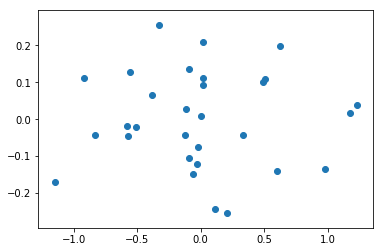

In [98]:
plt.scatter(transformed[:,0], transformed[:,1])

In [99]:
pca.fit(bopens.encs)
transformed = pca.fit_transform(bopens.encs)

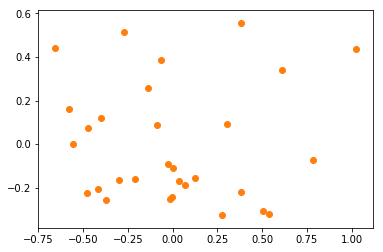

In [100]:
plt.scatter(transformed[:,0], transformed[:,1], color='#ff7f0e')

In [101]:
_data = np.append(closeds.encs, opens.encs, axis=0)

In [104]:
print(_data.shape) # check IO
pca.fit(_data)
transformed = pca.fit_transform(_data)

(60, 128)


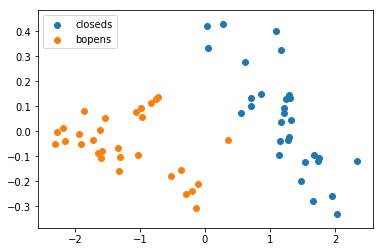

In [109]:
for ix, label in enumerate(['closeds', 'bopens']):
    if ix ==0:
        plt.scatter(transformed[:30,0], transformed[:30,1], label=label)
    else:
        plt.scatter(transformed[30:,0], transformed[30:,1], label=label)
plt.legend(loc='upper left')

In [110]:
pca.explained_variance_ratio_

array([0.94481844, 0.01542851], dtype=float32)

2


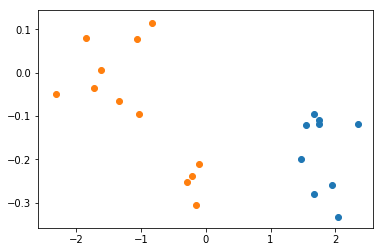

In [116]:
# PCA only for target cluster
print(cluster)
for ix, label in enumerate(['closeds', 'bopens']):
    if ix ==0:
         for j in  np.argwhere(c == cluster):
            plt.scatter(transformed[j[0],0], transformed[j[0],1], label=label, color='#1f77b4')
    else:
         for  l in np.argwhere(bo == cluster): 
            plt.scatter(transformed[30+l[0],0], transformed[30+l[0],1], label=label, color='#ff7f0e')
#plt.legend(loc='upper left')

In [115]:
lens= [len(np.argwhere(c == cluster)),
 len(np.argwhere(o == cluster)),
 len(np.argwhere(bc == cluster)),
 len(np.argwhere(bo == cluster))]
print(lens)

[9, 0, 0, 12]


PCA to latent space may not work for understanding the k-means classification

EMD in same cluster
--> EMD is applied to measure analogus of images 

# EMD 

Firstly, recall Cluster histogram

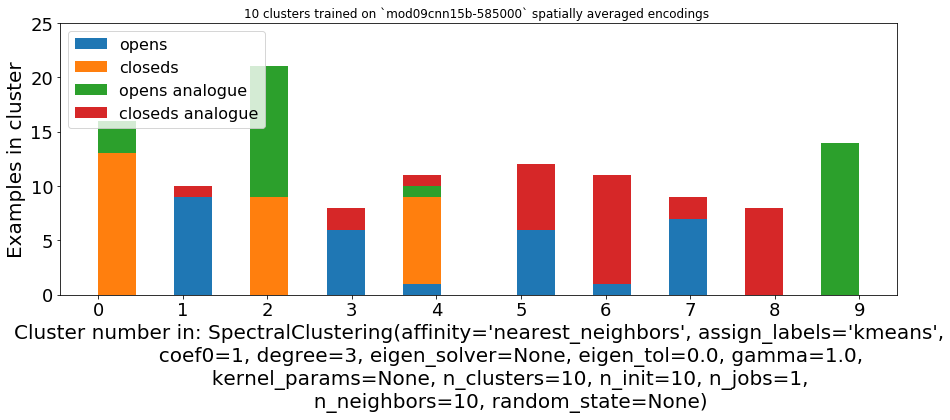

In [120]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([0,5,10,15,20, 25])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

### intra class between 0 vs 2 

Closeds vs Opens analogue

In [140]:
current_cluster = 0
## get distribution of latent vector
# get index
cid = np.argwhere(c==current_cluster)
boid = np.argwhere(bo==current_cluster)
# get latent list
clatent_list, bolatent_list = [], []
for i in cid:
    clatent_list += [closeds.encs[i[0]]]
for j in boid:
    bolatent_list += [bopens.encs[j[0]]]

In [141]:
emd = [wasserstein_distance(x,y) for x in clatent_list for y in bolatent_list if x is not y ]

Text(0.5,1,'cluster No.0 Closeds vs Opens analogue ')

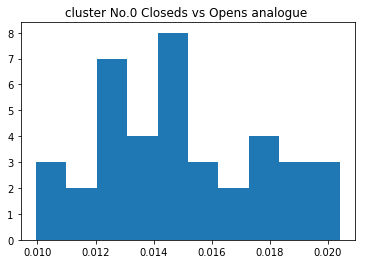

In [143]:
plt.hist(emd)
plt.title('cluster No.0 Closeds vs Opens analogue ')

In [136]:
current_cluster = 2
## get distribution of latent vector
# get index
cid = np.argwhere(c==current_cluster)
boid = np.argwhere(bo==current_cluster)
# get latent list
clatent_list, bolatent_list = [], []
for i in cid:
    clatent_list += [closeds.encs[i[0]]]
for j in boid:
    bolatent_list += [bopens.encs[j[0]]]

In [137]:
emd = [wasserstein_distance(x,y) for x in clatent_list for y in bolatent_list if x is not y ]

Text(0.5,1,'cluster No.2 Closds vs Opens analogue ')

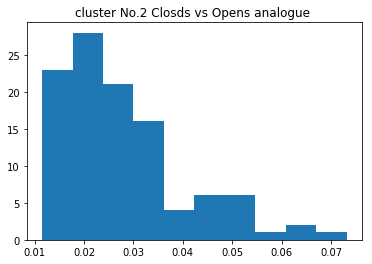

In [139]:
plt.hist(emd)
plt.title('cluster No.2 Closds vs Opens analogue ')

### intra clusters in 3 permutation types
closds-closeds / closeds-opens analogue / opens analogue-opens analogue

In [146]:
def _gen_emds(current_cluster, xcluster, ycluster, x_ae, y_ae):
    xid = np.argwhere(xcluster==current_cluster)
    yid = np.argwhere(ycluster==current_cluster)
    # get latent list
    x_list, y_list = [], []
    for i in xid:
        x_list += [x_ae.encs[i[0]]]
    for j in yid:
        y_list += [y_ae.encs[j[0]]]
    return x_list, y_list

In [147]:
c0_closeds, c0_bopens = _gen_emds(0, c,bo, closeds, bopens)

In [148]:
c2_closeds, c2_bopens = _gen_emds(2, c,bo, closeds, bopens)

In [163]:
emd1 = [wasserstein_distance(x,y) for x in c0_closeds for y in c2_closeds if x is not y ]

In [164]:
emd2 = [wasserstein_distance(x,y) for x in c0_closeds for y in c0_bopens if x is not y ]

In [165]:
emd3 = [wasserstein_distance(x,y) for x in c2_closeds for y in c2_bopens if x is not y ]

In [166]:
emd4 = [wasserstein_distance(x,y) for x in c0_bopens for y in c2_bopens if x is not y ]

In [177]:
emd5 = [wasserstein_distance(x,y) for x in c0_closeds for y in c2_bopens if x is not y ]

In [181]:
emd6 = [wasserstein_distance(x,y) for x in c2_closeds for y in c0_bopens if x is not y ]

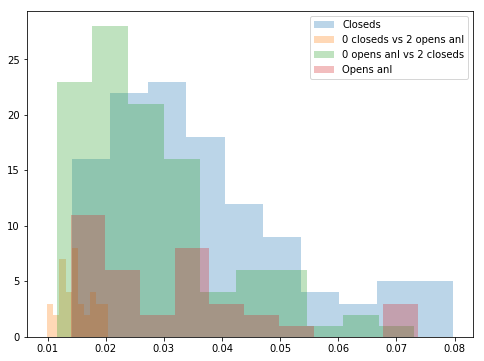

In [174]:
plt.figure(figsize=(8,6))
for i, label in zip([emd1, emd2, emd3, emd4], 
                    ['Closeds', '0 closeds vs 2 opens anl', '0 opens anl vs 2 closeds', 'Opens anl'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

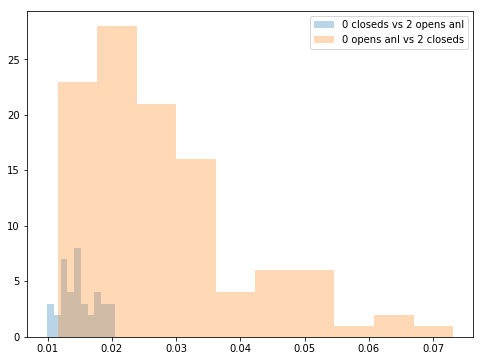

In [175]:
plt.figure(figsize=(8,6))
for i, label in zip([emd2, emd3], 
                    [ '0 closeds vs 2 opens anl', '0 opens anl vs 2 closeds'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

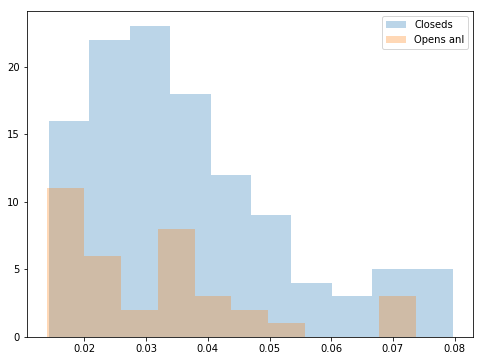

In [176]:
plt.figure(figsize=(8,6))
for i, label in zip([emd1, emd4], 
                    ['Closeds', 'Opens anl'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

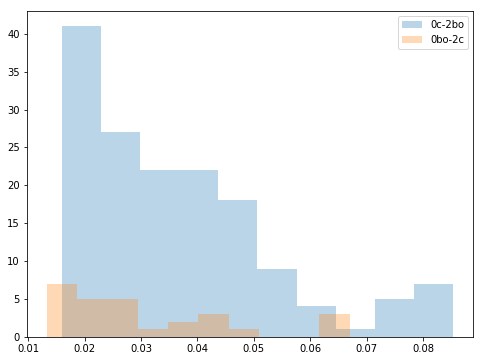

In [182]:
plt.figure(figsize=(8,6))
for i, label in zip([emd5, emd6], 
                    ['0c-2bo', '0bo-2c'] ):
    plt.hist(i, alpha=0.3, label=str(label))
plt.legend(loc='upper right')
plt.show()

==MEMO==
Given encoder or deep neural nets are sensitive towards object's shape, EMD(how close or far a pair of images) could work well.
Important point is how to connect cluster class and this metric

## intra classes among same image type

In [184]:
for i in range(num_clusters):
    print(" Current cluster == %d" %i)

 Current cluster == 0
 Current cluster == 1
 Current cluster == 2
 Current cluster == 3
 Current cluster == 4
 Current cluster == 5
 Current cluster == 6
 Current cluster == 7
 Current cluster == 8
 Current cluster == 9


# Upgrade Cluster number 

In [42]:
#  cluster
k.cluster_centers_ = centers
# Number of Clusters 
num_clusters = 20
# Append
oc = np.append(opens.encs,closeds.encs, axis=0)
boc = np.append(bopens.encs,bcloseds.encs, axis=0)
both = np.append(oc, boc,  axis=0)

In [43]:
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)
o, c, bo, bc = clusters[:N], clusters[N:N*2], clusters[N*2:N*3], clusters[N*3:]

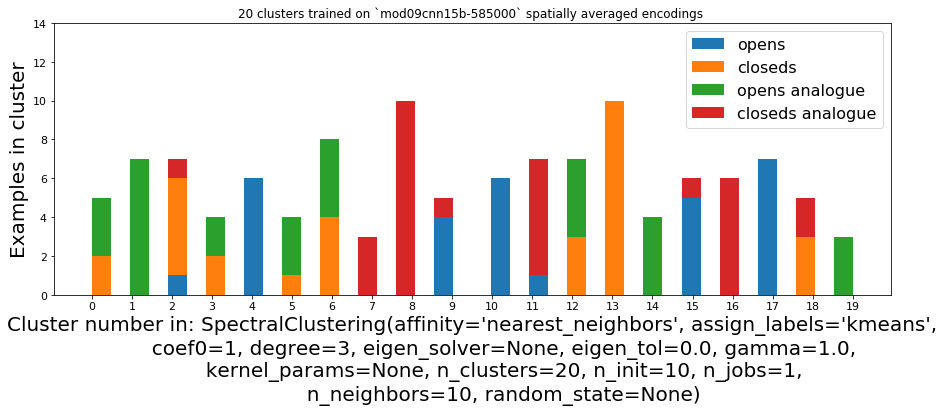

In [45]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([x for x in range(0,16,2)])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper right')
plt.tick_params(labelsize=11)

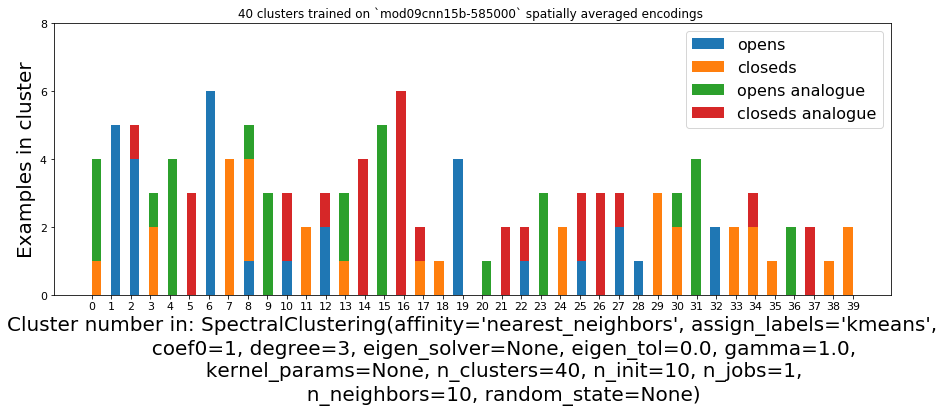

In [41]:
# Fig
plt.figure(figsize=(15, 5))
plt.hist([o,c,bo, bc], bins=num_clusters*2, 
         label=["opens", "closeds", "opens analogue", "closeds analogue"],
         stacked=True
        )
plt.xlabel("Cluster number in: "+str(method), fontsize=20)
plt.xticks(range(num_clusters))
plt.yticks([x for x in range(0,10,2)])
plt.ylabel("Examples in cluster", fontsize=20)
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings "%(num_clusters))
plt.legend(fontsize=16, loc='upper right')
plt.tick_params(labelsize=11)

# Sensitivity Check based on bands

Now. 7 bands have distinct radiance information.
Next, let's create one radiance band only 7 depth dataset, and then compare difference for check where is the most sensitivity layer to this classification or all layers are equally contributing to the result.